In [1]:
import sys
sys.path.append('../..')

from src.models import MLP
from main import get_dataloader_from_tensors, _convert_to_tensor, fit, train
from src.utils import make_performance_uncertainty_plot
import pandas as pd
import copy
%load_ext autoreload
import torch
from torch import nn
import matplotlib.pyplot as plt
%autoreload 2

torch.manual_seed(42)

In [2]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [3]:
train_loader = get_dataloader_from_tensors(_convert_to_tensor(X_train), _convert_to_tensor(y_train), 128)

test_loader = get_dataloader_from_tensors(_convert_to_tensor(X_test), _convert_to_tensor(y_test), 128)

In [4]:
class_weights = [1, 1 / y_train.mean().item()]
# class_weights = [1, 1]

In [5]:
class_weights

[1, 11.920710059171597]

In [6]:
model = MLP(44, 1, (128, 128), class_weights=class_weights)

In [7]:
fit(model, X_train, y_train, validate=True, X_val=X_test, y_val=y_test)

Epoch: 0 | Total Loss: 110.32 | 


Epoch: 1 | Total Loss: 106.48 | 


Epoch: 2 | Total Loss: 104.64 | 


Epoch: 3 | Total Loss: 104.92 | 


Epoch: 4 | Total Loss: 100.97 | 


Epoch: 5 | Total Loss: 98.98 | 


Epoch: 6 | Total Loss: 97.33 | 


Epoch: 7 | Total Loss: 102.87 | 


Epoch: 8 | Total Loss: 103.6 | 


Epoch: 9 | Total Loss: 95.0 | 


Epoch: 10 | Total Loss: 94.66 | 


Epoch: 11 | Total Loss: 96.17 | 


Epoch: 12 | Total Loss: 93.71 | 


Epoch: 13 | Total Loss: 93.01 | 


Epoch: 14 | Total Loss: 98.82 | 


Epoch: 15 | Total Loss: 93.76 | 


Epoch: 16 | Total Loss: 92.35 | 


Epoch: 17 | Total Loss: 93.06 | 


Epoch: 18 | Total Loss: 96.97 | 


Epoch: 19 | Total Loss: 90.64 | 


Epoch: 20 | Total Loss: 91.33 | 


Epoch: 21 | Total Loss: 92.07 | 


Epoch: 22 | Total Loss: 92.7 | 


Epoch: 23 | Total Loss: 91.13 | 


Epoch: 24 | Total Loss: 96.47 | 


Epoch: 25 | Total Loss: 89.84 | 


Epoch: 26 | Total Loss: 93.22 | 


Epoch: 27 | Total Loss: 89.4 | 


Epoch: 28 | Total Loss: 89.98 | 


Epoch: 29 | Total Loss: 92.09 | 


Epoch: 30 | Total Loss: 89.94 | 


Epoch: 31 | Total Loss: 89.38 | 


Epoch: 32 | Total Loss: 88.21 | 


Epoch: 33 | Total Loss: 87.41 | 


Epoch: 34 | Total Loss: 91.72 | 


Epoch: 35 | Total Loss: 87.18 | 


Epoch: 36 | Total Loss: 89.94 | 


Epoch: 37 | Total Loss: 89.25 | 


Epoch: 38 | Total Loss: 89.41 | 


Epoch: 39 | Total Loss: 89.37 | 


Epoch: 40 | Total Loss: 87.47 | 


Epoch: 41 | Total Loss: 89.31 | 


Epoch: 42 | Total Loss: 89.01 | 


Epoch: 43 | Total Loss: 88.3 | 
Loading saved parameters..


MLP(
  (f): Sequential(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (nll): BCEWithLogitsLoss()
)

In [23]:
model_confident = copy.deepcopy(model)
model_diffident = copy.deepcopy(model)

class_weights_confident = [1, y_train.mean().item() * 2]
weight_tensor = torch.Tensor([class_weights_confident[1]])
model_confident.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

In [24]:
class_weights_diffident = [1, y_train.mean().item() / 2]
weight_tensor = torch.Tensor([class_weights_diffident[1]])
model_diffident.nll = nn.BCEWithLogitsLoss(pos_weight=weight_tensor, reduction='sum')

In [25]:
# Train both models for 3 epochs.

for _ in range(10):
    train(model_confident, torch.optim.SGD(model_confident.parameters(), lr=1e-3), train_loader)
    train(model_diffident, torch.optim.SGD(model_diffident.parameters(), lr=1e-3), train_loader)

In [26]:
# fit(model_confident, X_train, y_train, validate=True, X_val=X_test, y_val=y_test)
# fit(model_diffident, X_train, y_train, validate=True, X_val=X_test, y_val=y_test)


In [27]:
with torch.no_grad():
    y_pred_logits = model(torch.from_numpy(X_test.values).float())

    y_pred_confident = model_confident(torch.from_numpy(X_test.values).float())

    y_pred_diffident = model_diffident(torch.from_numpy(X_test.values).float())

In [28]:
y_pred_logits

tensor([[-5.6590],
        [-2.9004],
        [-0.3116],
        ...,
        [-2.8623],
        [-1.2871],
        [-0.4675]])

In [29]:
uncertainty_logits = y_pred_confident - y_pred_diffident
uncertainty_probits = torch.sigmoid(y_pred_confident) - torch.sigmoid(y_pred_diffident)

y_pred_probits = torch.sigmoid(y_pred_logits)

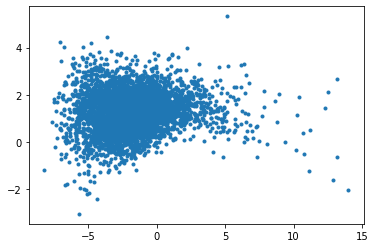

In [30]:
plt.scatter(y_pred_logits, uncertainty_logits, marker='.')

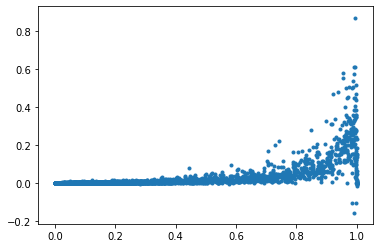

In [31]:
plt.scatter(y_pred_probits, uncertainty_probits, marker='.')

In [32]:
from sklearn.metrics import roc_auc_score

/Users/david/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


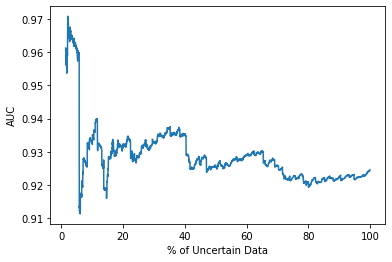

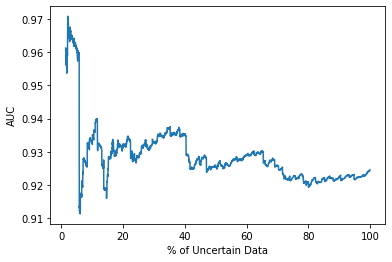

In [33]:
make_performance_uncertainty_plot(y_test.squeeze(), y_pred_probits.numpy(), uncertainty_logits.numpy(), 'AUC', roc_auc_score)

/Users/david/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


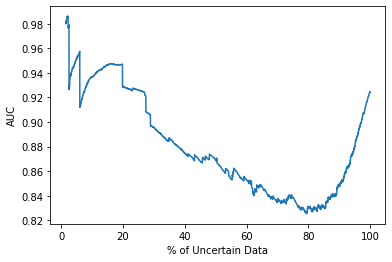

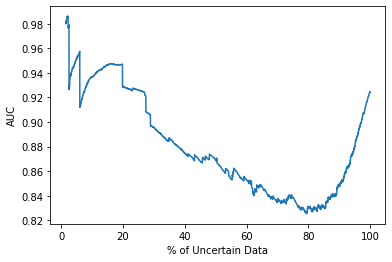

In [34]:
make_performance_uncertainty_plot(y_test.squeeze(), y_pred_probits.numpy(), uncertainty_probits.numpy(), 'AUC', roc_auc_score)